Bearing Monitoring and Analysis Algorithm
=========================================

LORD Sensing Systems
--------------------

In [1]:
import numpy as np
from scipy import signal
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib import cm, colors, pyplot, dates
from MathEngine import FFT as meFFT
import pylab as pl
from emailClassSensorCloudMSG import sensorCloudEmailMSG

#settins for plots
matplotlib.rcParams['figure.figsize'] = (12,5)
rcParams['savefig.dpi'] = 100

Get the bearing accelerometer data from SensorCloud
---------------------------------------------------

In [3]:
startTime=1406333142252025000
repo = TimeSeriesRepo('WSDA000000000000')
allSeries = repo.getAllTimeSeries( '21043', 'ch1', startTime=startTime, endTime=1407493430217023000 )


#print len(allSeries)
series = allSeries[0]

In [4]:
timestamps = series.getTimeStamps()
times = np.array(series.getTimeStamps())
data = np.array(series.getData())

In [5]:
#convert timestamps into seconds for plotting
start = times[0]
times = (times - start)/NANO_PER_SEC

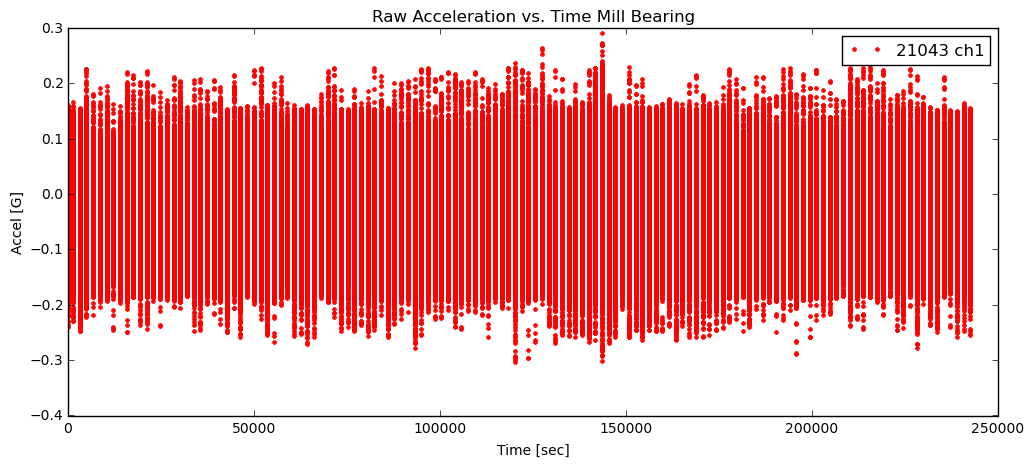

In [6]:
plot(times, data, '.r', label='21043 ch1')
xlabel('Time [sec]')
ylabel('Accel [G]')
title('Raw Acceleration vs. Time Mill Bearing')
pl.legend(loc='upper right')      

In [7]:
accel = data *  9.81

Filter accel data to remove DC offset
-------------------------------------

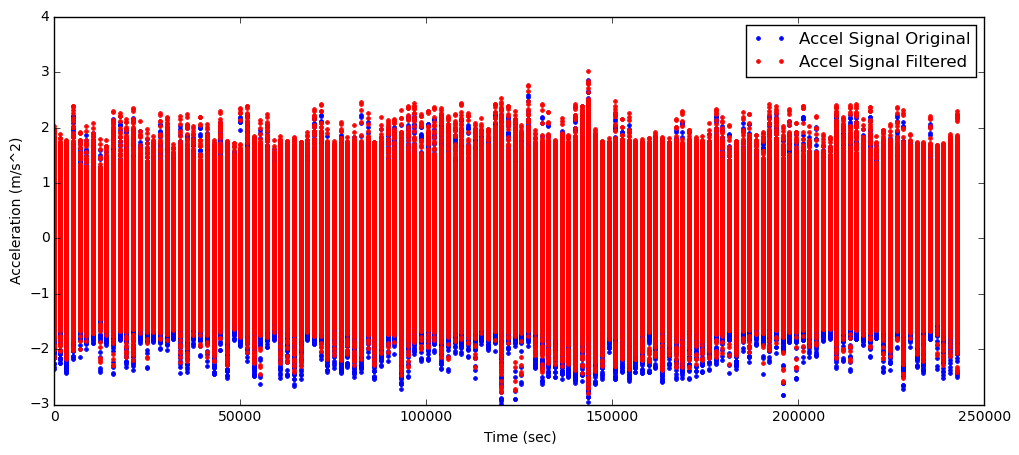

In [8]:
#highpass filter acceration to remove DC offset
from scipy import integrate, signal

Nyquist = series.getSampleRate()/2.0
filter_hz = 0.7 #everything above this freq is passband
filter_order = 3 #order of butterworth filter (too high of an order will introduce data unstabilities)

x, y = signal.butter(filter_order, (float(filter_hz)/Nyquist), btype='high')
accel_highpass = signal.filtfilt(x, y, accel)

#plot filtered accel signal over original signal
figure(1)
plot(times, accel, '.b', label='Accel Signal Original')
plot(times,accel_highpass, '.r', label='Accel Signal Filtered')
xlabel('Time (sec)')
ylabel('Acceleration (m/s^2)')
pl.legend()


Integrate for velocity and filter to remove drift
-------------------------------------------------

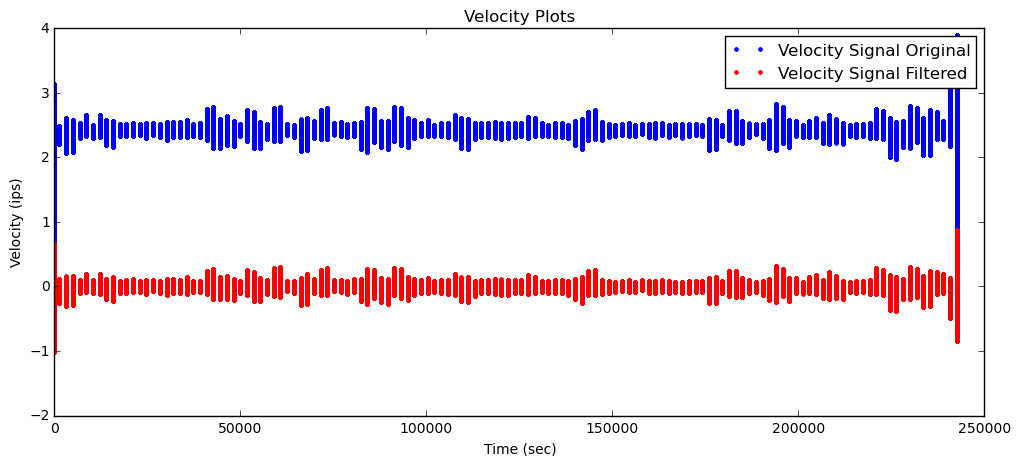

In [9]:
#integrate acceleration to get velocity
velocity = integrate.cumtrapz(accel_highpass, dx = 1.0/series.getSampleRate(), initial = 0)

#convert velocity from m/sec to in/sec
velocity_ips = velocity * 39.37

#highpass filter velocity to remove drift
x, y = signal.butter(filter_order, (float(filter_hz)/Nyquist), btype='high')
velocity_highpass_ips = signal.filtfilt(x, y, velocity_ips)

plot(times, velocity_ips, '.b', label='Velocity Signal Original')
plot(times, velocity_highpass_ips,'.r', label='Velocity Signal Filtered')
pl.legend(loc = 'upper right')
pl.title('Velocity Plots')
pl.xlabel('Time (sec)')
pl.ylabel('Velocity (ips)')

Integrate for position and filter to remove drift
-------------------------------------------------

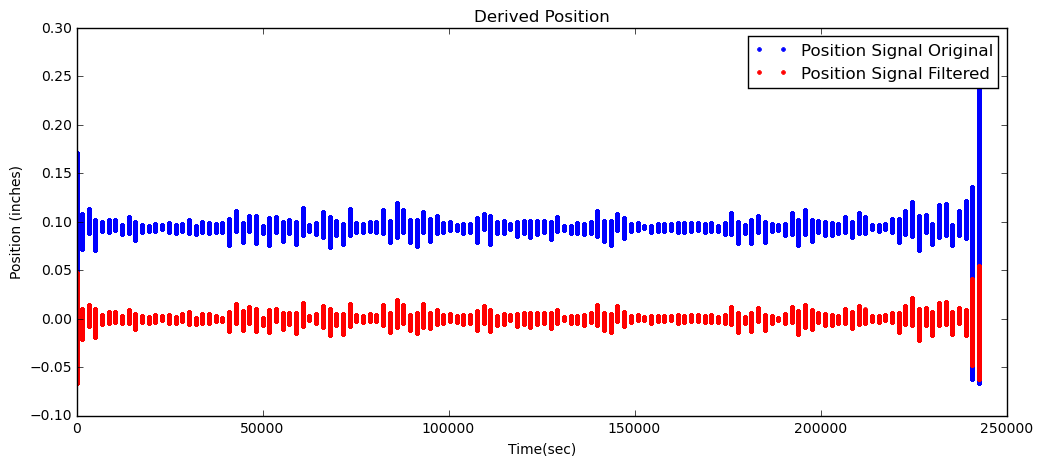

In [10]:
#integrate velocity to get position data
position = integrate.cumtrapz(velocity_highpass_ips, dx = 1.0/series.getSampleRate()) #initial condition not specified

#highpass filter position to remove drift
x, y = signal.butter(filter_order, (float(filter_hz)/Nyquist), btype='high')
position_highpass = signal.filtfilt(x, y, position) #position in inches

#plot position results.  Array is one point smaller than original due to integration without 0 initial condition setting
plot(times[1:], position, '.b', label = 'Position Signal Original')
plot(times[1:], position_highpass, '.r', label = 'Position Signal Filtered')
pl.legend()
pl.title('Derived Position')
pl.xlabel('Time(sec)')
pl.ylabel('Position (inches)')

Burst detection, sorting, and frequency analysis
------------------------------------------------

In [11]:
expectedTimePeriod = (1.0/series.getSampleRate())*NANO_PER_SEC

In [12]:
bursts = [] # List of detected burst segments
oldIndex = 0 # The start of the first burst        
oldTimestamp = timestamps[0]
burst_timestamp = [startTime]

for i, point in enumerate(velocity_highpass_ips):
    difference = timestamps[i] - oldTimestamp
         
    # If a gap in data is detected we assume we are at the end of a burst
    if difference > 1000*expectedTimePeriod:
        burstLength = velocity_highpass_ips[oldIndex:i]
        if len(burstLength) >= (series.getSampleRate()): #need a widgit here - burst length dependant on sample rate/node config (throw away bad bursts)
            bursts.append(velocity_highpass_ips[oldIndex:i])
            burst_timestamp.append(timestamps[oldIndex])
            oldIndex = i # The beginning of the next burst
        else:
            oldTimestamp = timestamps[i]
bursts.append(velocity_highpass_ips[oldIndex:])
print len(bursts), 'valid bursts found'

132 valid bursts found


In [13]:
from MathEngine import FFT, Filter

def getPsdFft(values, samplerate, xMin = None, xMax = None):
    import numpy as np
    out = np.absolute(np.fft.fft(values))**2
    freq = np.fft.fftfreq(out.size, 1.0/samplerate)
    
    out = out[1:len(out)/2]
    freq = freq[1:len(freq)/2]
    
    if xMin == None or xMin < 0.1:
        xMin = 0.1
    for i, value in list(enumerate(freq)):
        if value >= xMin:
            freq = freq[i:]
            out = out[i:]
            break
    
    if xMax != None:
        for i, value in reversed(list(enumerate(freq))):
            if value <= xMax:
                freq = freq[:i]
                out = out[:i]
                break
        
    return (out, freq)

#The RMS value of a set of values is the square root of the arithmetic mean (average) of the squares of the original values

def rmsAmplitude(values):
    returnValue = 0
    for x in values:
        returnValue += x**2
    returnValue = returnValue/len(values)
    returnValue = sqrt(returnValue)
    return returnValue

In [14]:
slope = 1
offset = 0
minFreq = 0
#maxFreq = series.getSampleRate()/2.0
maxFreq = 400
waterfall = []
maxVal = 0
fftValues = []
freqValues = [] 

for burst in bursts:
    scaledData = (np.array(burst) * slope) + offset
    fft, freq = FFT(scaledData, series.getSampleRate(), xMin = minFreq, xMax = maxFreq)
    fftValues.append(fft)
    freqValues.append(freq)
    fft[-1] = 0
    fft[0] = 0
    curMax = np.amax(fft/len(burst))
    if curMax > maxVal:
        maxVal = curMax
    waterfall.append(zip(freq,fft/len(burst)))
        
segments = len(bursts)


In [15]:
#create iso 10816-3 line arrays in ips
iso_base   = np.ones(len(bursts))
iso_yellow = iso_base * 0.091 #unrestriced
iso_orange = iso_base * 0.177 #restricted
iso_red    = iso_base * 0.279 #machine damage is occurring

#build x axis array for rmsAmplitude plot
cuts = np.arange(len(bursts))

In [16]:
#unpack waterfall tuple for quadrant FFT plotting
fspec1 = []
aspec1 = []
fspec2 = []
aspec2 = []
fspec3 = []
aspec3 = []
fspec4 = []
aspec4 = []
fspec5 = []
aspec5 = []
total = len(cuts)

for i in waterfall[1]:
    f, a = i
    fspec1.append(f)
    aspec1.append(a)
    
for i in waterfall[total/4]:
    f, a = i
    fspec2.append(f)
    aspec2.append(a)

for i in waterfall[total/2]:
    f, a = i
    fspec3.append(f)
    aspec3.append(a)

for i in waterfall[3*total/4]:
    f, a = i
    fspec4.append(f)
    aspec4.append(a)

#for i in waterfall[total-1]:
    #f, a = i
    #fspec4.append(f)
    #aspec4.append(a)
        

Peak detection algorithm
------------------------

In [17]:
#find peak amplitudes in frequency data

def peaks(data, step):
    final_index = []
    n = len(data) - len(data)%step # ignore tail
    slices = [ data[i:n:step] for i in range(step) ]
    peak_max = reduce(maximum, slices)
    peak_max_filtered = filter(lambda a: a>.0005, peak_max) #remove unwanted peaks from array
    
    for i in peak_max_filtered:
        curind = data.index(i)
        final_index.append(curind)
      
    return peak_max_filtered,final_index
    
peak_det, amp_det = peaks(aspec4, 66) #amplitude of peaks in aspec* data set with 66 step window 
#frequency of corresponding peaks in aspec* data set with 66 step window
#print peak_det, amp_det

for i, value in list(enumerate(amp_det)):
    if i == 1:
        print "The first gear mesh frequency is %d Hz and the subsequent harmonics are: " % value
    elif i > 1:
        print " " + str(value) + "Hz"   

The first gear mesh frequency is 66 Hz and the subsequent harmonics are: 
 132Hz
 265Hz
 333Hz


Plot 1/2, 3/4 FFT slices from data bundle
-----------------------------------------

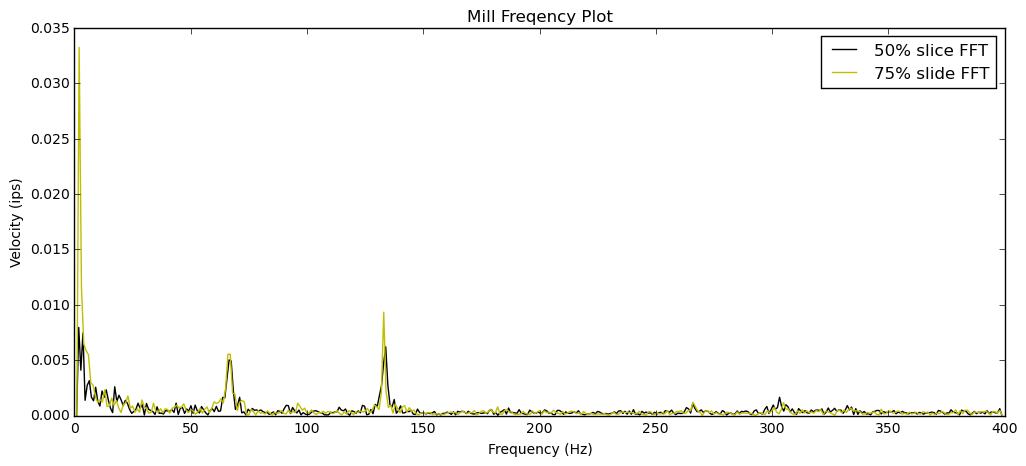

In [18]:
#plot frequency series in quadrants

#plot(fspec1, aspec1, 'r', label='0% slice FFT')
#plot(fspec2, aspec2, 'b', label='25% slice FFT')
plot(fspec3, aspec3, 'black', label = '50% slice FFT')
plot(fspec4, aspec4, 'y', label = '75% slide FFT')
#plot(fspec5, aspec5, 'orange', label='100% slice FFT')
#print total
title('Mill Freqency Plot')
xlabel('Frequency (Hz)')
ylabel('Velocity (ips)')
legend()
savefig('MillFrequencyPlot.png', dpi = 100) 

In [19]:
#create timestamp array from bursts for plotting
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates
import datetime

#convert epoch to matplotlib float format
d = np.array(burst_timestamp)

s = (d/NANO_PER_SEC)
ms = d-1000*s
dts = map(datetime.datetime.fromtimestamp, s)
fds = dates.date2num(dts)

#plt.subplots_adjust(bottom=0.2)
#plt.xticks( rotation=70 )
#ax=plt.gca()
#xfmt = DateFormatter('%Y-%m-%d %H:%M:%S')
#ax.xaxis.set_major_formatter(xfmt)
#ax.xaxis.set_ticks(np.arange(fds[0], fds[-1], .21))
#plt.plot(fds,rmsValue)
#plt.show()
midFds = fds[len(fds)/2]
#print midFds

Plot RMS velocity vs burst timestamp for trending using ISO 10816-3 limits
--------------------------------------------------------------------------

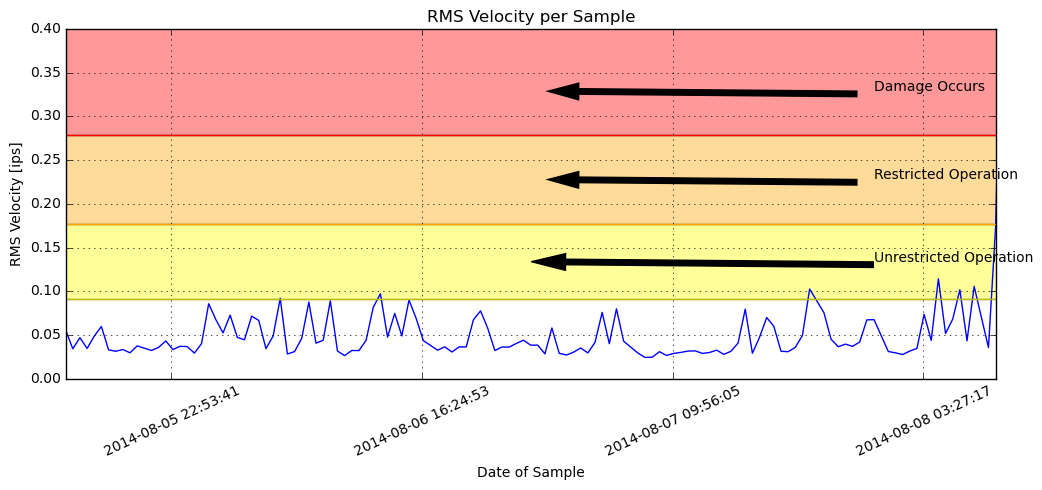

In [20]:
rmsValue = []
crestFactorValue = []
tempValue = []
burstTimestamps = []

for burst in bursts:
    scaledData = (np.array( map(lambda x: x, burst) )*slope) + offset
    burstTimestamps.append(np.array( map(lambda x: x, burst)))
    meanValue = np.mean(scaledData)
    rmsValue.append(rmsAmplitude(scaledData))

#yLimit = max(rmsValue) + (max(rmsValue)*.35)
yLimit = .4

plt.subplots_adjust(bottom=0.2)
plt.xticks( rotation=25 )
ax=plt.gca()
ax.grid(True)
xfmt = DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis.set_ticks(np.arange(fds[0], fds[-1], .73))
plt.plot(fds,rmsValue)
xlim(fds[3], fds[-3])
ylim([0, yLimit])
plot(fds, iso_yellow, 'y')
plot(fds, iso_orange, color='orange')
plot(fds, iso_red, 'r')
xlabel('Date of Sample')
ylabel('RMS Velocity [ips]')
title('RMS Velocity per Sample')

#create arrow indicators and fill between limit lines
annotate('Unrestricted Operation', xy=(midFds, iso_yellow[0]+((iso_orange[0] - iso_yellow[0])/2)), xytext=(midFds+1,(iso_yellow[0]+((iso_orange[0] - iso_yellow[0])/2))),arrowprops=dict(facecolor='black', shrink=0.002),)
annotate('Restricted Operation', xy=(midFds, iso_orange[0]+((iso_red[0] - iso_orange[0])/2)), xytext=(midFds+1, (iso_orange[0]+((iso_red[0]-iso_orange[0])/2))),arrowprops=dict(facecolor='black', shrink=0.05),)            

try:
    annotate('Damage Occurs', xy=(midFds, iso_red[0]+.05), xytext=(midFds+1, iso_red[0]+.05),arrowprops=dict(facecolor='black', shrink=0.05),)
except: ValueError
    
fill_between(fds, iso_yellow[0], iso_orange[0], facecolor='yellow', alpha = .4)
fill_between(fds, iso_orange[0], iso_red[0], facecolor='orange', alpha = .4)
fill_between(fds, iso_red[0], .6, facecolor='red', alpha = .4)

savefig('RMSVelocityPerSample.png', dpi = 100) 

Waterfall plot of all frequency data
------------------------------------

The detected Gear Mesh Frequencies are:
66 Hz, with an amplitude of 0.0055 ips
132 Hz, with an amplitude of 0.0093 ips
265 Hz, with an amplitude of 0.0012 ips
333 Hz, with an amplitude of 0.0007 ips


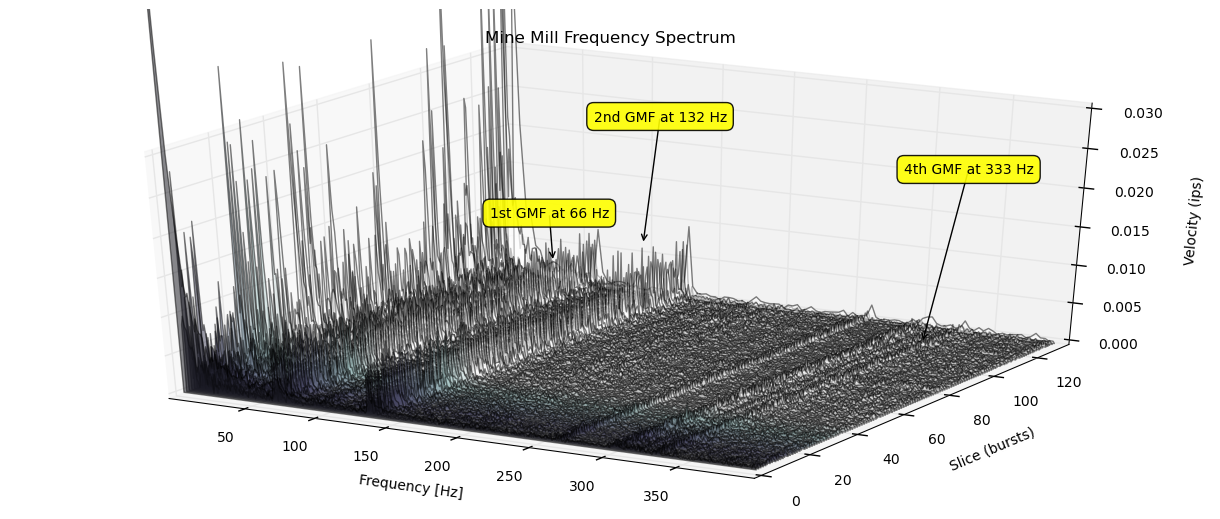

In [21]:
from mpl_toolkits.mplot3d import proj3d
fig = plt.figure()
ax = Axes3D(fig)
    
colors = [cm.bone(i) for i in np.linspace(.1,3,segments)]
col = PolyCollection(waterfall , facecolors = colors)
col.set_alpha(.5)
ax.add_collection3d(col, zs=np.arange(0,segments),zdir='y')
title('Mine Mill Frequency Spectrum')
ax.set_yscale('linear')
ax.set_xlabel('Frequency [Hz]')
ax.set_xlim(freq[0],freq[-1])
ax.set_ylabel('Slice (bursts)')
ax.set_ylim(0,segments)
ax.set_zlabel('Velocity (ips)')

maxAmp = .03

print "The detected Gear Mesh Frequencies are:"

for i in range(len(amp_det)):
    i+=1 #skip first peak (trash)
    try:
        print "%s Hz, with an amplitude of %s ips" % (amp_det[i], round(peak_det[i], 4))
    except:  IndexError
        
try:
    x1, y1, _ = proj3d.proj_transform(amp_det[1], (.85*total), (peak_det[1]/maxAmp), ax.get_proj())
    label = pylab.annotate("1st GMF at %d Hz" % amp_det[1],xy = (x1, y1), xytext = (40, 30),textcoords = 'offset points', ha = 'right', va = 'bottom',    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.9),arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
except IndexError:
       print "1st GMF was not detected in this data set"
    
try:
    x2, y2, _ = proj3d.proj_transform(amp_det[2], (.85*total), (peak_det[2]/maxAmp), ax.get_proj())
    label = pylab.annotate("2nd GMF at %d Hz" % amp_det[2],xy = (x2, y2), xytext = (60, 87),textcoords = 'offset points', ha = 'right', va = 'bottom',   bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.9),arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
except IndexError:
        print '2nd GMF was not detected in this data set'
    
try:
    x4, y4, _ = proj3d.proj_transform(amp_det[4], (.85*total), (peak_det[4]/maxAmp), ax.get_proj())
    label = pylab.annotate("4th GMF at %d Hz" % amp_det[4],xy = (x4, y4), xytext = (80, 120),textcoords = 'offset points', ha = 'right', va = 'bottom',bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.9),arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    
except IndexError:
    print "4th GMF was not detected in this data set"
    
if maxAmp == 0 or maxAmp > maxVal:
    ax.set_zlim(0,maxVal)
else:
    ax.set_zlim(0,maxAmp)

savefig('MillFrequencySpectrograph.png', dpi = 100) 